# Проектная работа: Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. 
В распоряжении имеется набор фотографий людей с указанием возраста.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта**

Построить модель для опредения приблизительного возраста человека по фотографии.

**Описание данных**

Набор данных находится в каталоге `datasets/faces/`:
* `/final_files` - каталог со всеми изображениями
* `labels.csv` - CSV-файл `labels.csv` с двумя признаками:
    * `file_name` - имя файла с изображением 
    * `real_age` -  возраст в годах

**Условия и ограничения**
* Для оценки качества модели использовать метрику MAE
* Значение целевой метрики на тестовой выборке должно быть не меньше $7$


**План работы**
1. Провести исследовательский анализ набора фотографий.
1. Подготовить данные к обучению.
1. Обучить нейронную сеть и рассчитайте её качество.

## environments

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

PATH = 'datasets/faces'

## Исследовательский анализ данных

Загрузим данные в перемеменную `df`:

In [2]:
df = pd.read_csv(f'{PATH}/labels.csv')

Изучим общую информацию:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Явных пропусков не вывлено.

Проверим на наличие дублирующихся записей:

In [4]:
df.duplicated().sum()

0

В наборе данных записей с явными признаками дублирования не вывлено.

Рассмотрим баланс набора данных:

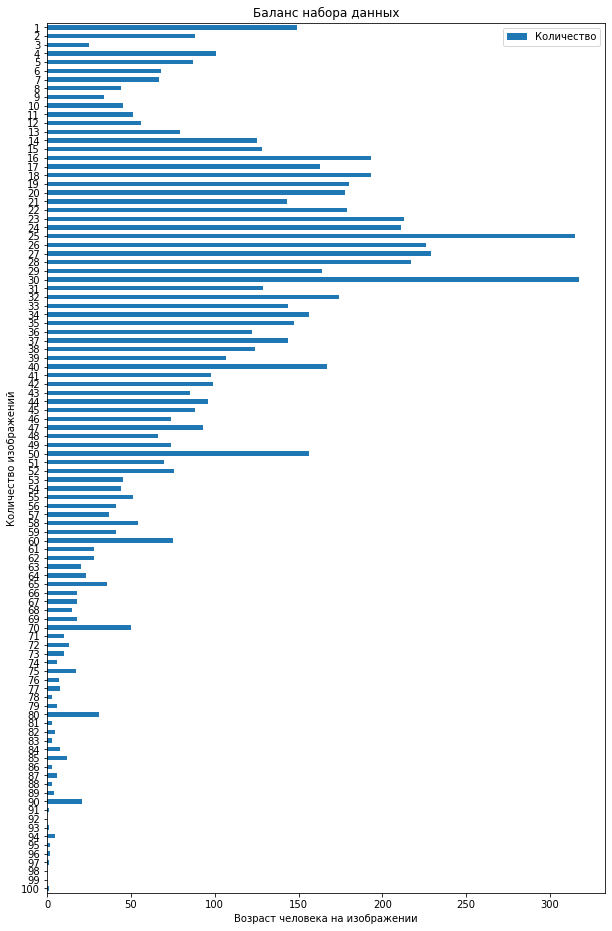

In [5]:
age = df.groupby('real_age').count()
missing_age = [
    i for i in range(age.index.min(), age.index.max() + 1) if i not in age.index
]
age = pd.concat(
    [age, pd.DataFrame([0 for _ in missing_age], index=missing_age, columns=['file_name'])]
)
age.sort_index(ascending=False, inplace=True)
ax = age.plot.barh(figsize=(10, 16), title='Баланс набора данных')
ax.set_xlabel("Возраст человека на изображении")
ax.set_ylabel("Количество изображений")
ax.legend(["Количество"]);
plt.show()

Набор данных имеет существенное смещение, но поскольку мы решаем задачу регрессии, имеющихся данных достаточно. 
При этом следует создать обучающую и проверочную выборки с учетом этого распределения.

Выведем примеры 15 случайных фотографий:

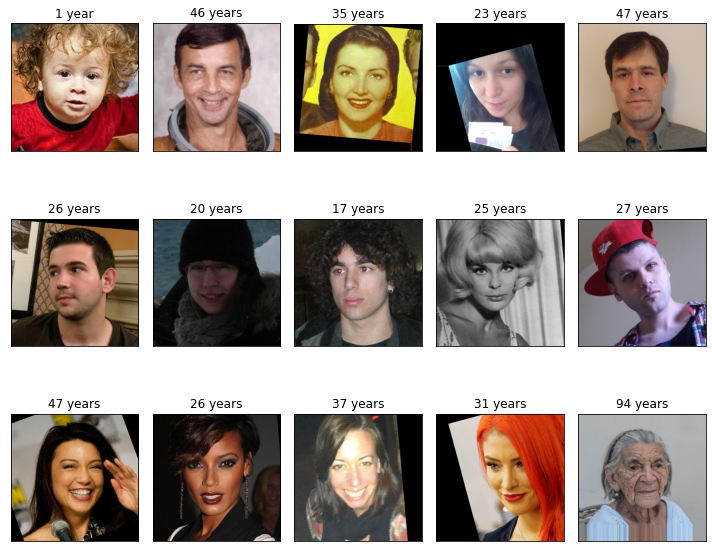

In [6]:
examples = df.sample(15, random_state=42)

fig = plt.figure(figsize=(10,10))

for e, (image, age) in enumerate(zip(examples.file_name.values, examples.real_age.values)):
    fig.add_subplot(3, 5, e+1)
    plt.imshow(np.array(Image.open(f'{PATH}/final_files/{image}')))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{age} year' if age == 1 else f'{age} years')
    plt.tight_layout()

**Вывод**. В ходе анализа был изучен набор данных, который показал, что возраст людей на фотографиях колеблется от 1 до 100 лет включительно. Распределение числа фотографий для каждого возраста ассиметрично, но учитывая, что решается задача регрессии, то имеющееся распределение приемлемо и фотографий в количестве 7591 достаточно.

Изучение отдельных изображений показало, что большинство фотографий лиц людей расположено в центре, при этом на некоторых фотографиях можно заметить вертикальные и горизонтальные смещения.
Поэтому рекомендуемым аугментациями могут быть горизонтальные отражения и смещения относительно обоих осей на 10%.

## Подготовка данных

Для обучения будем использовать 75% данных, а для тестирования - 25%:

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        seed=12345
    )
    return train_datagen_flow


def load_test(path):
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        seed=12345
    )
    return val_datagen_flow
```

## Обучение модели

```python

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


def create_model(input_shape):
    optimizer = Adam(lr=1e-4)
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False,
                        
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(
        model, train_data, test_data, 
        batch_size=None, 
        epochs=15, 
        steps_per_epoch=None, 
        validation_steps=None
    ):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
              
    return model

```

```
Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/15: 178/178 - 115s - loss: 274.3695 - mae: 11.6472 - val_loss: 646.3540 - val_mae: 20.4494
Epoch 2/15: 178/178 - 87s - loss: 92.5639 - mae: 7.2480 - val_loss: 634.9028 - val_mae: 20.1884
Epoch 3/15: 178/178 - 87s - loss: 68.1504 - mae: 6.2941 - val_loss: 329.3810 - val_mae: 13.3886
Epoch 4/15: 178/178 - 92s - loss: 53.8257 - mae: 5.5689 - val_loss: 118.4407 - val_mae: 8.0558
Epoch 5/15: 178/178 - 93s - loss: 44.6817 - mae: 5.1238 - val_loss: 103.1937 - val_mae: 7.6408
Epoch 6/15: 178/178 - 87s - loss: 39.6151 - mae: 4.8364 - val_loss: 78.0413 - val_mae: 6.3474
Epoch 7/15: 178/178 - 87s - loss: 32.6999 - mae: 4.4136 - val_loss: 72.1857 - val_mae: 6.1987
Epoch 8/15: 178/178 - 87s - loss: 28.7108 - mae: 4.1346 - val_loss: 79.7171 - val_mae: 6.8560
Epoch 9/15: 178/178 - 87s - loss: 26.8408 - mae: 3.9724 - val_loss: 88.3095 - val_mae: 6.8622
Epoch 10/15: 178/178 - 87s - loss: 21.8441 - mae: 3.6335 - val_loss: 102.2466 - val_mae: 7.5996
Epoch 11/15: 178/178 - 87s - loss: 20.7098 - mae: 3.5180 - val_loss: 74.3310 - val_mae: 6.2840
Epoch 12/15: 178/178 - 87s - loss: 21.1001 - mae: 3.5477 - val_loss: 74.9719 - val_mae: 6.5658
Epoch 13/15: 178/178 - 87s - loss: 17.4591 - mae: 3.2378 - val_loss: 68.6751 - val_mae: 6.2454
Epoch 14/15: 178/178 - 87s - loss: 14.6875 - mae: 2.9811 - val_loss: 74.7752 - val_mae: 6.4088
Epoch 15/15: 178/178 - 87s - loss: 13.4436 - mae: 2.8089 - val_loss: 69.8090 - val_mae: 6.1259

60/60 - 9s - loss: 69.8090 - mae: 6.1259

Test MAE: 6.1259
```

## Анализ обученной модели

**Вывод**. \
Для решения задачи проекта была использована предобученная модель ResNet50, для обучения которой веса модели не замораживались. Вместо 1000 классов был использован один выход с функцией активации `RELU`.

Обучение выполнялось на протяжении 15 эпох с использованием оптимизатора Adam с начальным шагом 1е-4.
На протяжении обучения модели явных признаков ее переобучения не замечено.
Значение целевой метрики на валидационной выборке достигло значения 6.12, что удовлетворяют заданному критерию.

Таким образом цель проекта достигнута при заданных условиях и ограничениях.